## **Fake news prediction**

Now it's time to apply some ML algorithms to our data and try to make a model which can distinguish between fake and real news articles

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve, plot_confusion_matrix, accuracy_score, f1_score
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")

In [3]:
news_df = pd.read_csv('news_df_cleaned.csv')

<AxesSubplot:xlabel='classification'>

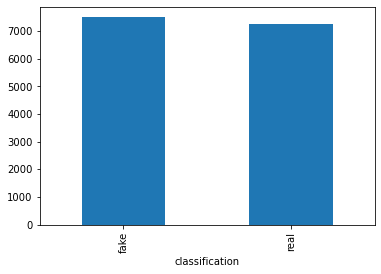

In [3]:
# check we have an even distribution of fake and real news

news_df.groupby(['classification']).size().plot(kind='bar')

In [4]:
fake_df = news_df[news_df['classification'] == 'fake']
real_df = news_df[news_df['classification'] == 'real']

**Convert the clasification column to an integer so the models can process it**

In [5]:
fake_df["class"] = 0
real_df["class"] = 1

**Merging the two dfs into one df again**

In [6]:
df_merged = pd.concat([fake_df, real_df], axis =0 )
df_merged

,headline,text,classification,text_cleaned,text_transformed,headline_cleaned,headline_transformed,headline_text_merged,class
7262,WikiLeaks: Podesta Had Disturbing ‘Beyond Disc...,"by Baxter Dmitry in News , US // 0 Comments ...",fake,by baxter dmitry in news us comments a new wi...,baxter dmitry news u comment new wikileaks ema...,wikileaks podesta had disturbing beyond discip...,wikileaks podesta disturbing beyond discipline...,wikileaks podesta disturbing beyond discipline...,0
7263,Trump elected as President – risks and opportu...,"13904 Views November 09, 2016 193 Comments Ana...",fake,views november comments analyses the saker so...,view november comment analysis saker happened ...,trump elected as president risks and opportuni...,trump elected president risk opportunity,trump elected president risk opportunity view ...,0
7264,Break the Silence or Support Self-Determinatio...,B y Danny Haiphong S yria is “the target of on...,fake,b y danny haiphong s yria is the target of one...,b danny haiphong yria target one greatest misi...,break the silence or support self determinatio...,break silence support self determination syria...,break silence support self determination syria...,0
7265,Re: donald-trump-accepts-the-nomination-public...,Wilderness Survival Copyright © 2016 The Econo...,fake,wilderness survival copyright the economic col...,wilderness survival copyright economic collaps...,re donald trump accepts the nomination public ...,donald trump accepts nomination public domain,donald trump accepts nomination public domain ...,0
7266,Re: More Than 101 Million Working Age American...,More Than 101 Million Working Age Americans Do...,fake,more than million working age americans do not...,million working age american job michael snyde...,re more than million working age americans do ...,million working age american job,million working age american job million worki...,0
...,...,...,...,...,...,...,...,...,...
7257,2020 Census Results Show Big Changes to Americ...,"According to the 2020 United States Census, th...",real,according to the united states census the u s ...,according united state census u white hispanic...,census results show big changes to america s ...,census result show big change america racial e...,census result show big change america racial e...,1
7258,"Dems and GOP Strike Short-Term Deal on Debt, b...",Democrats and Republicans have reached a tempo...,real,democrats and republicans have reached a tempo...,democrat republican reached temporary solution...,dems and gop strike short term deal on debt bu...,dems gop strike short term deal debt larger di...,dems gop strike short term deal debt larger di...,1
7259,January 6 Committee Votes to Hold Steve Bannon...,"On Tuesday evening, the House Committee invest...",real,on tuesday evening the house committee investi...,tuesday evening house committee investigating ...,january committee votes to hold steve bannon i...,january committee vote hold steve bannon conte...,january committee vote hold steve bannon conte...,1
7260,Biden Picks Susan Rice to Lead Domestic Policy...,Statecertified 2020 presidential election winn...,real,statecertified presidential election winner jo...,statecertified presidential election winner jo...,biden picks susan rice to lead domestic policy...,biden pick susan rice lead domestic policy cou...,biden pick susan rice lead domestic policy cou...,1


**Dropping the unecessary columns**

In [7]:
df_merged = df_merged.drop(columns=['headline', 'text', 'classification', 
'text_cleaned', 'headline_cleaned'])

In [8]:
df_merged['headline_text_merged'] = df_merged['headline_text_merged'].dropna()

**Randomly shuffle df and reset the index**

In [9]:
df_merged = df_merged.sample(frac = 1)

In [10]:
df_merged.reset_index(inplace = True)
df_merged.drop(["index"], axis = 1, inplace = True)
df_merged.head(10)

,text_transformed,headline_transformed,headline_text_merged,class
0,u missile defense agency navy successfully con...,u conduct missile defense test hawaii coast,u conduct missile defense test hawaii coast u ...,1
1,leading u attorney warned staffer many america...,podesta clinton twisted behavior smack acting ...,podesta clinton twisted behavior smack acting ...,0
2,spain friday issued arrest warrant sedition ch...,spain issue arrest warrant ousted catalan leader,spain issue arrest warrant ousted catalan lead...,1
3,lebanon cabinet meet tuesday first time since ...,lebanon cabinet meet tuesday first time since ...,lebanon cabinet meet tuesday first time since ...,1
4,need revolution overcoming fascism movement lo...,need revolution overcoming fascism movement love,need revolution overcoming fascism movement lo...,0
5,effectiveness pfizerbiontech covid vaccine fal...,pfizer covid vaccine effectiveness fall percen...,pfizer covid vaccine effectiveness fall percen...,1
6,home bombed martin luther king jr applied perm...,supreme court hear major second amendment case,supreme court hear major second amendment case...,1
7,key british hope moving talk trade tie europea...,eu say irish final say brexit border deadline ...,eu say irish final say brexit border deadline ...,1
8,president nicolas maduro predicted new foreign...,venezuela maduro upbeat talk opposition fear s...,venezuela maduro upbeat talk opposition fear s...,1
9,hillary spent million clinton foundation priva...,hillary spent million clinton foundation priva...,hillary spent million clinton foundation priva...,0


**X/y split**

In [11]:
# lets test the article text and the headline and see which returns a better result

X = df_merged['headline_text_merged']
y = df_merged['class']

**Testing some different ML algorithms**

- we will try logistic regression, decision tree, random forest, KNN and support vector to classify our data.
- before the classification stage we also need to transform our text into vectors (numeric representations of the text) so that the algorithm can process it.
- i will use the TF IDF vectorizer.
- TF stands for term frequency and is a measure of how frequently a term appears in a document.
- IDF stands for inverse document frequency and is a measure of how important a term is in the corpus.
- this process essentially turns the words into features for the algorithm to process.

In [12]:

def model_tester(X, y):

    # x/y split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    # here are the 3 models we will try out

    models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        KNeighborsClassifier(n_neighbors=3)
    ]

    # we will use a pipeline here to quickly check all 3 models after vectorizing the X data
    # vectorization maps the text to a corresponding vector of real numbers so that it can be processed by a ML algorithm

    for model in models:
        pipe = Pipeline(
            steps=[
            ("tfidf", TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore')),
            ("classifier", model),
            ])
        pipe.fit(X_train.values.astype('U'), y_train) 
        # print the scores for each model
        print(model)
        print("model score: %.3f" % pipe.score(X_test.values.astype('U'), y_test))
    



In [15]:
model_tester(X, y)

LogisticRegression()
model score: 0.951
DecisionTreeClassifier()
model score: 0.889
RandomForestClassifier()
model score: 0.939
SVC()
model score: 0.958
KNeighborsClassifier(n_neighbors=3)
model score: 0.907


**The best model is support vector machine**

- The support vector machine algorithm tries to find a hyperplane in an N-dimensional space (N = the number of features) that distinctly classifies the data points.
- Lets check the best parameters for this model using grid search

In [21]:
# find best paramters for support vector machine
def sv_best_params(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    
    pipe = Pipeline(
        steps= [
        ("tfidf", TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore')),
        ("classifier", SVC())
            ])
    pipe.fit(X_train.values.astype('U'), y_train) 

    params = { 
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'classifier__C': [0.01, 0.1, 1, 10]
    }
        
        
    CV = GridSearchCV(pipe, params, cv= 2, n_jobs= 2, verbose=2)
                  
    CV.fit(X_train.values.astype('U'), y_train)  
    print(CV.best_params_)    
    print(CV.best_score_)

In [22]:
sv_best_params(X,y)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
{'classifier__C': 10, 'tfidf__ngram_range': (1, 1)}
0.9536793035161512


**Lets test the algorithm with some real and fake news texts and see what it predicts**

- SVM was the most accurate model so I will use this one for the predictions in combination with the best hyperparamters returned via gridsearch

In [12]:
# support vector machine was the best model so I will use this one for the predictions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

tfidf = TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore', ngram_range=(1,1))
    
vector = tfidf.fit(X_train.values.astype('U'))
xv_train = vector.transform(X_train.values.astype('U'))
xv_test = vector.transform(X_test.values.astype('U'))

SV = SVC(random_state=101, C=10, kernel= 'linear')#'rbf

SV.fit(xv_train, y_train)
round(SV.score(xv_test, y_test),3)


0.962

**Lets check some metrics before making some predictions**

In [17]:
predictions = SV.predict(xv_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1507
           1       0.96      0.97      0.96      1446

    accuracy                           0.96      2953
   macro avg       0.96      0.96      0.96      2953
weighted avg       0.96      0.96      0.96      2953



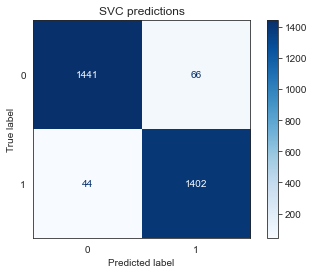

In [18]:
sns.set_style('white')
fig = plot_confusion_matrix(SV, xv_test, y_test, cmap='Blues')
plt.title('SVC predictions')
plt.show()

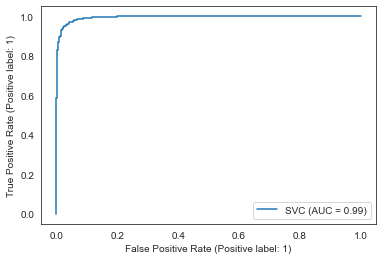

In [23]:
plot_roc_curve(SV, xv_test, y_test)

**Most important features**


In [32]:
importance = np.argsort(np.asarray(xv_train.sum(axis=0)).ravel())[::-1]
tfidf_feature_names = np.array(tfidf.get_feature_names())
tfidf_feature_names[importance[:20]]

array(['said', 'trump', 'clinton', 'state', 'people', 'election',
       'hillary', 'government', 'president', 'new', 'year', 'party',
       'russia', 'country', 'time', 'american', 'email', 'war', 'say',
       'world'], dtype='<U129')

In [20]:
# Function for removing the stopwords and lemmatizing the text 
# this is needed to process the input for the function to test unseen news articles

def text_transform(text):

    stopwords = nltk.corpus.stopwords.words('english')
    lemma = WordNetLemmatizer()
    #Defining empty string
    string = ""
    
    for word in str(text).split():
        if word not in stopwords:
            string+=lemma.lemmatize(word)+" "
    
    return string

In [21]:
def fake_or_real():

    text = input("Enter text here")

    text_cleaned = text_transform(text)    

    X = vector.transform([text_cleaned])
   
    predicted_class = SV.predict(X)
    print(predicted_class)
    
    if predicted_class == 0:
        print(text)
        return  "Prediction: Fake news!"
    else:
        print(text)
        return "Prediction: real news!"
    

Lets test the model on some articles from reuters

In [26]:
fake_or_real()

[1]
Qualcomm Inc (QCOM.O) said on Tuesday it expects chip sales to Apple Inc (AAPL.O) to dwindle to a trickle in the coming years but predicted brisk growth in chips for autonomous cars and other connected devices, sending shares up 7.9% to a record high close of $181.81


'Prediction: real news!'

In [33]:
fake_or_real()

[1]
The jury at Kyle Rittenhouse’s murder trial began deliberating for a third day Thursday with a new defense request for a mistrial hanging over the politically and racially fraught case.  The mistrial bid was sparked by a jury request Wednesday to re-watch video evidence, including drone footage that prosecutors used to try to undermine Rittenhouse’s self-defense claim and portray him as the instigator of the bloodshed in Kenosha in the summer of 2020.  Prosecutors said the video showed him pointing his rifle at protesters before the shooting erupted.  But the defense team said Wednesday that it had received an inferior copy of the potentially critical video from prosecutors, prompting its second mistrial motion in a week. Judge Bruce Schroeder agreed to let the jury re-watch the video and did not immediately rule on the mistrial request.  Rittenhouse attorney Corey Chirafisi said the defense would have approached things differently if it had received the better footage earlier in t

'Prediction: real news!'

Lets try some articles from the financial times

In [38]:
fake_or_real()

[1]
S jury has acquitted a teenager who killed two men during civil unrest in Kenosha, Wisconsin last year, in a case that has sharply divided public opinion on the right and left.  The jury handed down the verdict for Kyle Rittenhouse, 18, on the fourth day of deliberations. He was found not guilty on all five counts. After the jury’s verdict, Rittenhouse fell to the ground and then rose into the arms of one of his attorneys.  Jurors had considered five charges against Rittenhouse, the most serious being intentional homicide, which carries a mandatory life sentence. He also was charged with first-degree reckless homicide, first-degree attempted homicide and first-degree reckless endangerment of public safety. The judge dismissed a firearms charge shortly before the trial ended.  The prosecution had described Rittenhouse as an armed “chaos tourist” who travelled to Kenosha “looking for trouble”. His attorneys had argued that he acted in self-defence during the protests in Kenosha, port

'Prediction: real news!'

In [39]:
fake_or_real()

[1]
When Pascal Soriot unveiled AstraZeneca’s new vaccine strategy he could scarcely hide his exasperation. After thrusting his company into the frontline of the battle against Covid by developing a low-cost jab, the chief executive appeared frustrated he was not receiving the plaudits he might have expected.  “I know some people find it difficult to believe but we did actually start this project to help,” he told reporters last week.  The Anglo-Swedish drugmaker refused to initially make a profit on the 2bn vaccines it made with the University of Oxford, while rivals were pocketing billions. This year it has made a loss on the vaccine of 3 cents per share.  But setbacks, from delayed deliveries to a rare side effect and lower efficacy rates than mRNA jabs, have garnered the wrong kind of headlines. Last week, Soriot appeared to be steeling himself for a new wave of criticism after he announced the company would now make a “modest” profit in high and middle income countries, while keep

'Prediction: real news!'

In [41]:
fake_or_real()

[1]
Dutch insurance veteran and Citigroup board member Alex Wynaendts is set to succeed Paul Achleitner as Deutsche Bank chair next year, the German lender announced late on Friday night, ending a months-long search in which its regulators had become increasingly impatient.  Wynaendts retired as chief executive officer at Dutch insurance company Aegon last year after a 12 years in the role.  Achleitner, a former Goldman Sachs banker and Allianz chief financial officer, joined Deutsche Bank’s board in 2012 and last year said that he would not be available for a third five-year term in 2022.  The 65-year-old Austrian has been the focus of repeated criticism from investors and analysts as Deutsche Bank has gone through a very tough patch over recent years. Its investment bank was hit hard by the fallout of the financial crisis and adjusted much later than its US peers to the new environment.  In late 2019, private equity investor Cerberus pushed for Achleitners exit, trying to replace him

'Prediction: real news!'

In [33]:
fake_or_real()

[1]
Visa’s chief executive called Amazon’s decision to ban UK-issued credit cards from its platform “odd” and “unfortunate,” but said he expects the spat to be resolved.  “Clearly, we’re in a challenging negotiation,” Al Kelly told the Financial Times. “What’s different here is that Amazon unfortunately decided to take the negotiation challenges that we’re having public and oddly has chosen to threaten to punish consumers.”  Amazon on Wednesday notified customers it would stop accepting UK-issued Visa credit cards starting next year and offered affected customers £20 off their next purchase using an alternative payment method. The retailer also said it was weighing dropping Visa as the partner for its co-branded card in the US.   “This should not be considered a shock, as Amazon has been using every negotiating tactic available to bring down the cost of processing payments,” Autonomous analyst Kenneth Suchoski wrote in a note that said Amazon’s move would have little impact on Visa’s b

'Prediction: real news!'

In [34]:
fake_or_real()

[1]
The club’s board held an emergency meeting on Saturday night after a 4-1 defeat at Watford, the fifth defeat in seven Premier League matches.  Manchester United, owned by the US billionaire Glazer family, said on Sunday that Solskjaer had “left his role”.  “Ole will always be a legend at Manchester United and it is with regret that we have reached this difficult decision,” the club said. “While the past few weeks have been disappointing, they should not obscure all the work he has done over the past three years to rebuild the foundations for long-term success.”  Michael Carrick, coach and former player, will take charge for upcoming matches, with the club confirming that it will seek to appoint an interim manager until the end of the season.  The Norwegian was the club’s fourth manager since Sir Alex Ferguson retired in 2013, the last time the club won the Premier League.  Hopes were high for this season after the club spent heavily on new players, including big outlays on transfer

'Prediction: real news!'

In [35]:
fake_or_real()

[1]
Joe Biden’s battle to pass a $1.75tn package to enhance the social safety net and combat climate change moves to the thorny terrain of the US Senate, after clearing the House of Representatives.  The House on Friday passed the sweeping Build Back Better bill, which includes subsidies for early childhood education, tax credits for families with children, an expansion of public healthcare for senior citizens and some $550bn in programmes to combat climate change.  The vote came just days after Biden signed into law a separate $1.2tn bipartisan infrastructure package that will fund repairs to bridges, roads, tunnels and other transport systems.  It was a significant achievement for a president who has been trying to regain momentum after months of declining approval ratings and a disappointing showing for his party in state and local elections this month.  “We will be telling our children and grandchildren that we were here this day,” Nancy Pelosi, the Democratic Speaker of the House,

'Prediction: real news!'

In [36]:
fake_or_real()

[1]
The Netherlands faced a second night of riots on Saturday over the introduction of new restrictions to curb the spread of Covid-19, leading to dozens of arrests across the country, while protests broke out elsewhere in Europe after authorities imposed further measures to counter the virus.  Dutch authorities deployed mounted police, dogs and water cannon after protesters in three provinces set fires and threw fireworks, in the worst outburst of violence in the country since a full lockdown led to widespread disorder at the start of the year.  The protests were sparked by plans to restrict the use of the Covid pass to those who have either been vaccinated or have recovered from Covid-19. Previously it also covered people with a negative test result. A ban on fireworks for New Year’s Eve celebrations also roused anger.  In The Hague on Saturday night, five police officers were injured and seven people were arrested, according to an official statement. Police charged at protesters on 

'Prediction: real news!'

In [46]:
fake_or_real()

[1]
African-American turnout is key to US election result  Democrats at pains to avoid mistakes of 2016 when black voters came out in fewer numbers  A woman wears a mask with a message urging voter participation while she waits in line to enter a polling place on the first day of North Carolina’s in-person early voting for the general election in Durham on October 15 © Jonathan Drake/Reuters  In many parts of the American South, Sundays in October are synonymous with four words: souls to the polls.  In African-American churches in particular, there is a long history of congregants attending services, listening to sermons espousing civic engagement, and then driving — or in some cases, being driven by the busload — to polling stations to cast their ballots.  This year few churches are gathering in-person because of concerns about Covid-19. But civic organisations and Democratic groups, especially in key swing US states such as North Carolina, Georgia and Florida, say the pandemic has no

'Prediction: real news!'

In [47]:
fake_or_real()

[1]
Emotional Clinton sees her dream of returning to the White House disappear  Candidate struggles to come to terms with second devastating defeat of her career  	An emotional Hillary Clinton said Donald Trump deserved “the chance to lead” after his election victory, but acknowledged to her stunned supporters that it was “painful” to see her dream of winning the White House slip through her hands.  In a speech in New York that she gave hours after conceding defeat, the Democratic candidate said the tradition of a stable t ransition of power to a new president now needed to be respected.  “We owe him [Mr Trump] an open mind and the chance to lead,” she said.  But Mr Trump’s victory, which shocked the Clinton campaign, has left the former secretary of state struggling to come to terms with the second devastating defeat of her political career, following the loss to President Barack Obama in the 2008 primaries. This time, however, there is no way back.  Having stymied the chances of the 

'Prediction: real news!'

The model has predicted all the articles from the FT correctly. 

Now let's try with some fake articles
- These have been taken from the website realrawnews.com which has been identified as fake by the fact checking website snopes.

In [37]:
fake_or_real()

[1]
U.S. Special Forces arrested former President George W. Bush Saturday morning at his Crawford, Texas, ranch following a blistering firefight with Secret Service agents and private security contractors assigned to protect him. On Friday evening, a Special Forces “Alpha Detachment” stationed at Fort Campbell, Kentucky, received from U.S. Army Special Operations Command orders to infiltrate the ranch and arrest the 43rd president. SF were told to expect resistance because recent intelligence on the ranch showed that Bush had surrounded himself with armed private security contractors in addition to the trio of Secret Service agents that routinely patrolled the grounds. Transportation to the ranch was provided by the 160th Special Operations Aviation Regiment, nicknamed Night Stalkers, a group of highly skilled chopper pilots that conduct transport, attack, assault, and reconnaissance missions, at night, at low altitude, and on short notice. The choppers had to make 3 refueling stops to

'Prediction: real news!'

This is an incorrect prediction


In [38]:
fake_or_real()

[1]
A military tribunal on Thursday convicted former Secretary of State Hillary Clinton on charges of murder, conspiracy to commit murder, accessory to murder, child trafficking, endangering a minor, treason, and sedition. The two male, one female panel of officers cast a unanimous verdict shortly after Vice Adm. John G. Hannink, who prosecuted the military’s case against Clinton, showcased his final witness for the prosecution, Clinton’s former strategist and lover, Huma Abedin. In exchange for leniency and a plea deal, Abedin testified she and Clinton had “shared” underage children with her estranged ex-husband, Anthony Weiner. Pressed to clarify her definition of the word “shared,” Abedin qualified her answer by saying they had “practiced” lewd and lascivious behavior on underprivileged minors Clinton had imported into the United States. “American children?” Vice Adm. Hannink asked. “Yes, but not primarily. They’re too easy to track. More often than not from poor countries,” Abedin 

'Prediction: real news!'

This is incorrectly indentified as real news

In [39]:
fake_or_real()

[0]
Shamed California Governor Gavin Newsom had ulterior motives for living at his luxurious $4m estate instead of at the Governor’s Mansion, as is customary for governors of all 50 states, for the Marines who arrested him on 1 November returned to his Fair Oaks home and made a shocking discovery: a child pornography dungeon in the basement of the 7,500sq-foot home. A JAG source told RRN that a Marine reconnaissance team visited the estate on 2 November to “gather evidence” and ascertain whether Mrs. Newsom and the couple’s four children were still secreted in the panic room to which they had fled the morning of Newsom’s arrest. “The house appeared empty, and Marines couldn’t tell if the family was still locked in the safe room. They used thermal imaging and acoustic gear, but they still weren’t sure. And they didn’t want to breach the room with explosives and wound or kill the kids,” our source said. Then they hit pay dirt. While examining Newsome’s office, the Marines found a conceal

'Prediction: Fake news!'

This article was correctly identified!

In [40]:
fake_or_real()

[0]
Disgraced politician, murderer, and sexual predator Andrew Cuomo was hanged at Guantanamo Bay early Tuesday morning for his role in perpetrating the global plandemic and callously killing thousands of senior citizens who, were it not for his actions, might still be alive today. At 6:00 a.m. the humiliated former governor ate his last meal, steak and eggs, after which GITMO security drove him to the southern edge of the installation where JAG and Office of Military Commission officers anxiously awaited his arrival. Predictively, Cuomo did not go gracefully into the night; the ineloquent, foul-mouthed, bovine Cuomo seemed to thrive on hurling insults at everyone he met that morning, from GITMO security to the Marines who drove him to the execution site, from Vice. Adm. Crandall to the anonymous hangman who slipped a braided noose around his neck. But his flippant obscenities only hastened his execution. “I spit on every one of you motherfuckers,” a petulant Cuomo said as his Marine g

'Prediction: Fake news!'

This one was also correctly identified

In [41]:
fake_or_real()

[0]
Marc Mezvinsky’s testimony resumed Thursday morning, and his remarks helped slammed shut Chelsea Clinton’s proverbial coffin. Rear Adm. Crandall opened the day by asking Mezvinsky about the 3 Haitian children who were passengers in Chelsea’s rented Mercedes at the time of her arrest. “They were imported into the country some time ago; I don’t remember exactly when. They were meant to be gifts to a friend of the Clinton foundation,” Mezvinsky said. “Interesting vernacular you have there. You use the word ‘imported’ as if they were a crate of microchips or lettuce. I think the words ‘abducted’ and ‘smuggled’ are more appropriate, don’t you? Who was this friend?” Rear Adm. Crandall asked. Mezvinsky said he did not know. He claimed that he was to wait in the vehicle while Chelsea escorted the children to a hotel room in Rockport, Massachusetts. He also denied knowledge of the youngsters’ names, for Chelsea, like her mother, indecipherably scrambled proper names into anagrams to thwart 

'Prediction: Fake news!'

In [43]:
fake_or_real()

[1]
Pilots of Southwest Airlines and other major U.S. carriers have good reason for resisting vaccination mandates. Their fellow pilots who had taken the controversial Covid-19 vaccine have been dropping dead on both domestic and international flights. Two weeks ago, Dr. Jane Ruby claimed on the Stew Peters Show that a Delta Airlines pilot died inflight, shortly after the pilot had received a second dose of the Covid-19 vaccination. The mainstream media, Delta, and the so-called fact-checking agencies quickly dismissed the claim, calling it false and unsubstantiated—mainly because the claimant did not supply the name of the pilot, the flight number, or the points of origin and destination for the flight. Nonetheless, Real Raw News felt the issue deserved further investigation. Although we cannot authenticate Dr. Ruby’s specific incident, we learned that at least two freshly vaccinated pilots had dropped dead midflight within weeks of having received a Covid-19 vaccination. An FAA whist

'Prediction: real news!'

This is incorrectly indentified.

In [44]:
fake_or_real()

[0]
Hillary Clinton Hanged at GITMO  Scrambled eggs with jalapeno peppers, and a strawberry milkshake. The last meal of the condemned. Hillary Rodham Clinton was hanged at Guantanamo Bay Monday night, her death the culmination of an operation that began on March 2 when U.S. Navy SEALs on Donald J. Trump’s authority arrested the disgraced politician at her Chappaqua, NY mansion. After a five-day tribunal at the world’s most infamous detention center, a three-officer panel found Clinton guilty of murder, accessory to murder, treason, child trafficking, and other high crimes. Clinton, who had refused counsel, had uttered nary a word throughout the proceedings, and had taken Vice Adm. John G. Hannink’s sentence of death with an unflinching gaze. The hanging took place at 9:05 p.m., at once after Taps, which marks the start of quiet hours on U.S. military bases across the globe. “The world is about to sleep quieter tonight,” Vice Adm. John G. Hannink said to a small assembly that included 3

'Prediction: Fake news!'

In [45]:
fake_or_real()

[0]
Trump Assassination Foiled, Deep State in Panic Mode!   UPDATE: WE HAVE JUST PUBLISHED A FOLLOW-UP TO THIS STORY: TRUMP ASSASINATION ATTEMPT — NEW DETAILS SUGGEST BIDEN/CIA DRONE On Tuesday morning, January 26, at approximately 3:00 am, a sniper’s bullet struck a panoramic casement window on the east wall of Trump’s bedroom at his Mar-a-Lago estate. The round might have slain Trump had he not recently replaced tempered glass with Blast Structures International’s bullet resistant glass, which, according to the company’s website, can stop anything less powerful than a .50 round. A confidential source within Trump’s inner circle told Real Raw News that Trump was asleep in bed, and, a light sleeper, was awakened by the “sharp crack” of the bullet striking glass. The round did not penetrate the glass, but caused a material-science dissipation fracture, or spiderweb pattern. The strike, our source said, triggered a silent alarm that instantly notified the Palm Beach Police Dept. and Trum

'Prediction: Fake news!'

This one is correctly identified.
Overall 4/8 articles from this site were correctly identified.  

The majority of the correctly identified fake news articles tested here mention hillary clinton or donald trump. The fake news data the model was trained on was from 2016 which indicates the model performs well on news stories related to the 2016 election but less so on contemporary articles.
